In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
# import tensorflow_probability as tfp
import time

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# dSprites - Disentanglement testing Sprites dataset

## Description
Procedurally generated 2D shapes dataset. This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite (color isn't varying here, its value is fixed).

All possible combinations of the latents are present.

The ordering of images in the dataset (i.e. shape[0] in all ndarrays) is fixed and meaningful, see below.

We chose the smallest changes in latent values that generated different pixel outputs at our 64x64 resolution after rasterization.

No noise added, single image sample for a given latent setting.

## Details about the ordering of the dataset

The dataset was generated procedurally, and its order is deterministic.
For example, the image at index 0 corresponds to the latents (0, 0, 0, 0, 0, 0).

Then the image at index 1 increases the least significant "bit" of the latent:
(0, 0, 0, 0, 0, 1)

And similarly, till we reach index 32, where we get (0, 0, 0, 0, 1, 0). 

Hence the dataset is sequentially addressable using variable bases for every "bit".
Using dataset['metadata']['latents_sizes'] makes this conversion trivial, see below.

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})


In [5]:
# Load dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',encoding="bytes")
dataset_zip.allow_pickle=True
print('Keys in the dataset:', list(dataset_zip.keys()))
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)


Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']
Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214

In [6]:
ds = dataset_zip

In [7]:
ds['imgs'].shape

(737280, 64, 64)

In [8]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples


In [9]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

## Randomly sampling into the dataset

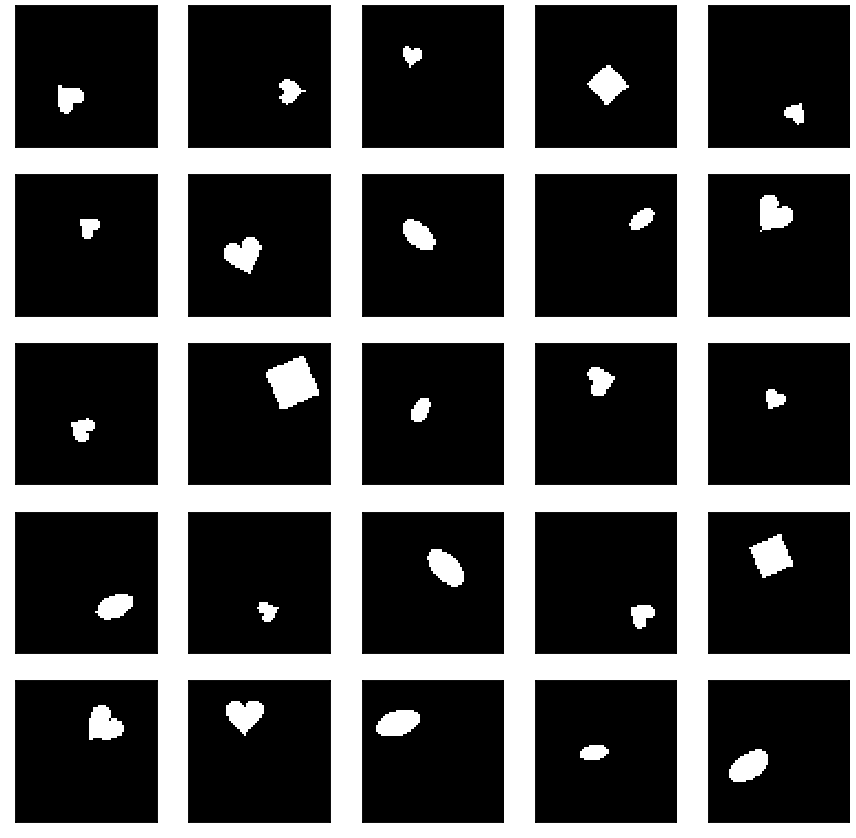

In [10]:
# Sample latents randomly
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled)

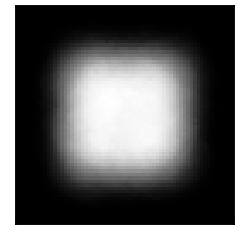

In [11]:
# Compute the density of the data to show that no pixel ever goes out of
# the boundary. Obviously it also means that the main support of the pixels is in the center
# half. 
# Locations cover a square, which make the aligned X-Y latents more likely for
# models to discover.

show_density(imgs_sampled)

## Conditional sampling of the dataset

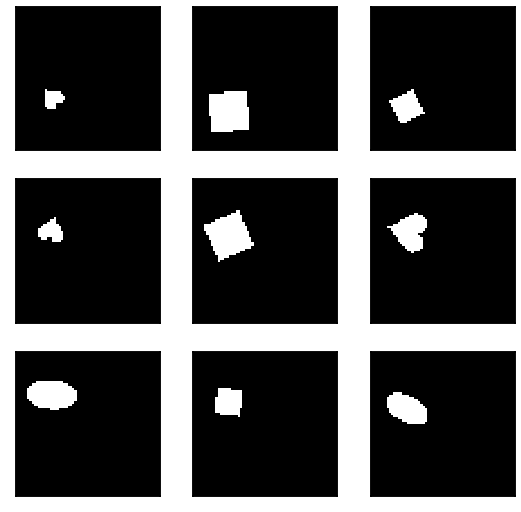

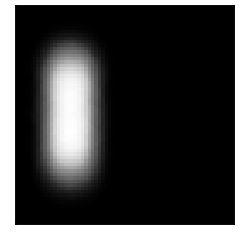

In [12]:
## Fix posX latent to left
latents_sampled = sample_latent(size=5000)
latents_sampled[:, -2] = 0
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Show the density too to check
show_density(imgs_sampled)

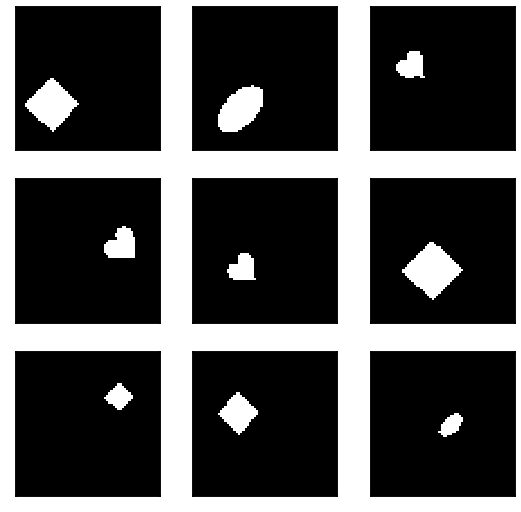

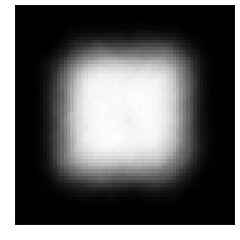

In [13]:
## Fix orientation to 0.8 rad
latents_sampled = sample_latent(size=5000)
latents_sampled[:, 3] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Density should not be different than for all orientations
show_density(imgs_sampled)

In [14]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPool2D, Reshape, Flatten

from keras.models import Model
from keras.callbacks import TensorBoard
from keras import metrics

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_context('poster')

import tensorflow as tf

import keras

import keras.layers

# Preprocessing

In [15]:
import sklearn

In [16]:
import sklearn.model_selection

In [17]:
dataset_size = 737280
# dataset_size = 5000

In [18]:
ix_all = np.arange(dataset_size)

In [19]:
ix_train, ix_test = sklearn.model_selection.train_test_split(ix_all, test_size=0.25, random_state=42)

In [20]:
X_raw = imgs.reshape(-1, 64,64,1)
y_raw = latents_values

In [21]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_raw, y_raw, test_size=0.25, random_state=42)

In [22]:
train_shuffle_size = 1000
test_shuffle_size  = 1000
batch_size = 32

train_images, test_images = X_train, X_test


In [23]:

def preprocess_images(images):
  images = images.reshape((images.shape[0], 64, 64, 1))
  # return np.where(images > .5, 1.0, 0.0).astype('float32') / 255.0
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [24]:

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X, batch_size=32, shuffle=True):
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.X = X.copy()
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.X)

    def __getitem__(self, index):
        
        X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        return X
    
    def __len__(self):
        return len(self.X) // self.batch_size

In [25]:
train_dataset = CustomDataGen(train_images)
test_dataset = CustomDataGen(test_images)

# VAE

## prepare datasets

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [26]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def log_normal_pdf(
    sample,
    mean,
    logvar,
    raxis=1,
    ):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar)
                         + logvar + log2pi), axis=raxis)



In [27]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


class CVAE(tf.keras.Model):

    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = \
            tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(64,
                                64, 1), batch_size=None),
                                tf.keras.layers.Conv2D(filters=32,
                                kernel_size=3, strides=(2, 2),
                                activation='relu'),
                                tf.keras.layers.Conv2D(filters=64,
                                kernel_size=3, strides=(2, 2),
                                activation='relu'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(latent_dim
                                + latent_dim)])  # No activation

        self.decoder = tf.keras.Sequential([  # No activation
            tf.keras.layers.InputLayer(input_shape=(latent_dim, )),
            tf.keras.layers.Dense(units=16 * 16 * 32,
                                  activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3,
                    strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                    strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3,
                    strides=1, padding='same'),
            ])
    
    @tf.function
    def compute_loss(self, x):
        (mean, logvar) = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit,
                labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)


    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)


    @tf.function
    def train_step(self, x):
        """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """

        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,
                self.trainable_variables))

        return {'loss': loss}

    def encode(self, x):
        (mean, logvar) = tf.split(self.encoder(x),
                                  num_or_size_splits=2, axis=1)
        return (mean, logvar)

    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)
        


## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [28]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 6
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
model = CVAE(latent_dim)

2022-05-02 23:03:22.542602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 23:03:24.982429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2022-05-02 23:03:24.983483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9639 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5
2022-05-02 23:03:24.984499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /j

In [29]:
from pathlib import Path

In [30]:
s = Path(".")

In [31]:
str(s)

'.'

In [32]:
list(s.glob("image*.png"))

[]

In [33]:
from keras.callbacks import Callback
from pathlib import Path



class ImageSaver(Callback):
    
    def __init__(self, log_dir, test_sample):
        super().__init__()

        self.test_sample = test_sample
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(parents=True, exist_ok=True)


    def set_model(self, model):
        self.model = model
        # self.writer = tf.summary.FileWriter(self.log_dir, filename_suffix='images')

    def on_train_begin(self, _):
        self.on_epoch_end(0)

    def on_train_end(self, _):
        anim_file = self.log_dir.joinpath('epoch_progress.gif')

        with imageio.get_writer(anim_file, mode='I') as writer:
            filenames = list(self.log_dir.glob('image*.png'))
            filenames = sorted(filenames)
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)
        import tensorflow_docs.vis.embed as embed
        embed.embed_file(anim_file)
        
                
    def generate_and_save_images(self, epoch):
        model = self.model
        test_sample = self.test_sample
        (mean, logvar) = model.encode(test_sample)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')
            
        plt.savefig(self.log_dir.joinpath('image_at_epoch_{:04d}.png'.format(epoch)))
        # plt.show()
            

    def on_epoch_end(self, epoch, logs={}):
        self.generate_and_save_images(epoch)


In [34]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
assert test_dataset.shuffle
test_dataset.on_epoch_end() # shuffle


In [35]:
len(train_dataset),len(test_dataset)

(17280, 5760)

In [36]:
import time

In [37]:
total_epochs = 10

In [38]:
epochs=10

In [39]:
model.compile(optimizer=optimizer)

In [40]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="cvae_dsprites_checkpoints", 
    save_freq='epoch')

In [41]:
test_sample = [test_dataset[42][i] for i in range(num_examples_to_generate)]
test_sample = np.array(test_sample)

callbacks = [
    cp_callback,
    ImageSaver(log_dir="cvae_training_progress_images", test_sample=test_sample)]

In [ ]:
model.fit(train_dataset, epochs=20, callbacks=callbacks)

2022-05-02 23:03:28.032191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-05-02 23:03:28.204737: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-05-02 23:03:28.295673: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1/20
17279/17280 [============================>.] - ETA: 0s - loss: 141.1748

2022-05-02 23:05:43.209165: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cvae_dsprites_checkpoints/assets
17280/17280 [==============================] - 135s 8ms/step - loss: 141.1685
Epoch 2/20
17280/17280 [==============================] - 134s 8ms/step - loss: 89.4266
Epoch 3/20
17280/17280 [==============================] - 135s 8ms/step - loss: 86.1974
Epoch 4/20
17280/17280 [==============================] - 135s 8ms/step - loss: 84.7404
Epoch 5/20
17280/17280 [==============================] - 135s 8ms/step - loss: 83.8005
Epoch 6/20
17280/17280 [==============================] - 135s 8ms/step - loss: 82.8851
Epoch 7/20
 9318/17280 [===============>..............] - ETA: 1:01 - loss: 81.6208

In [ ]:
model.build(input_shape = (None,) + (64,64,1))

In [ ]:
model.save("saved_final")

### Display a generated image from the last training epoch

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file("cvae_training_progress_images/epoch_progress.gif")